In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


aapl_df = pd.read_csv("stocks/AAPL.csv")
exxon_df = pd.read_csv("stocks/XOM.csv")
chevron_df = pd.read_csv("stocks/CVX.csv")
conoco_df = pd.read_csv("stocks/COP.csv")

In [4]:
def format(df, start = "2019-01-01", end = "2019-04-30"):
    df = df[(df["Date"] > start) & (df["Date"] < end)]
    df["returns"] = (((df["Close"] - df["Open"]) / df["Open"])*100)+100
    df = df.reset_index(drop=True) 
    return df

def graph_df(df):
    plt.figure(figsize=(20, 10))
    sns.scatterplot(data=df, x=df.index, y="returns", color = "orange")
    plt.plot(df.index, df['returns'], color='orange', linewidth=1)
    plt.show()

/tmp/ipykernel_171640/2666347190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = (((df["Close"] - df["Open"]) / df["Open"])*100)+100


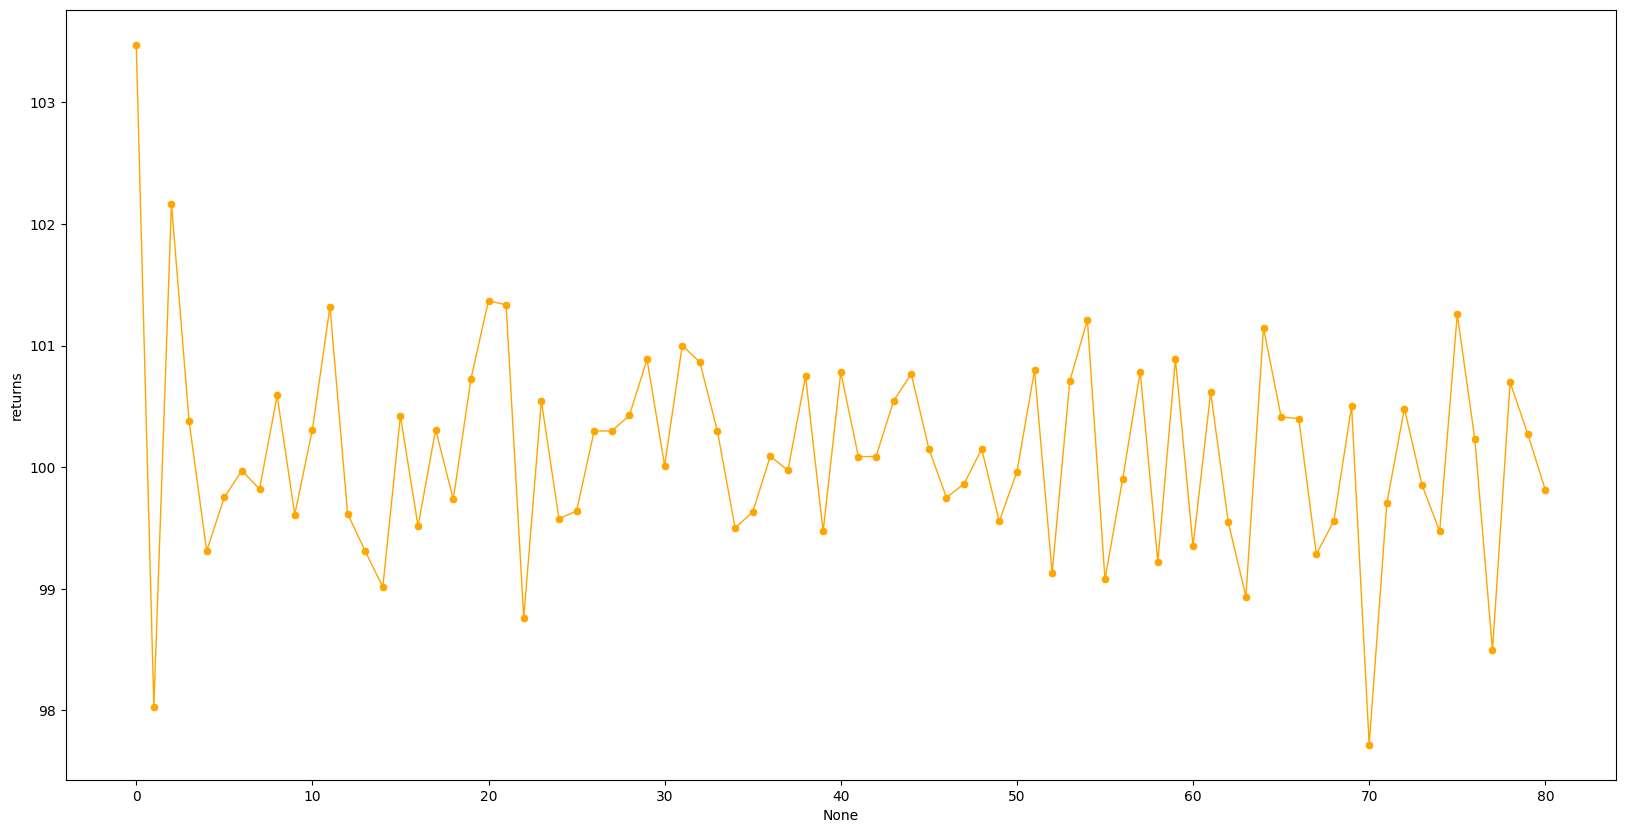

In [5]:
exxon_df = format(exxon_df)
graph_df(exxon_df)

/tmp/ipykernel_171640/2666347190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = (((df["Close"] - df["Open"]) / df["Open"])*100)+100


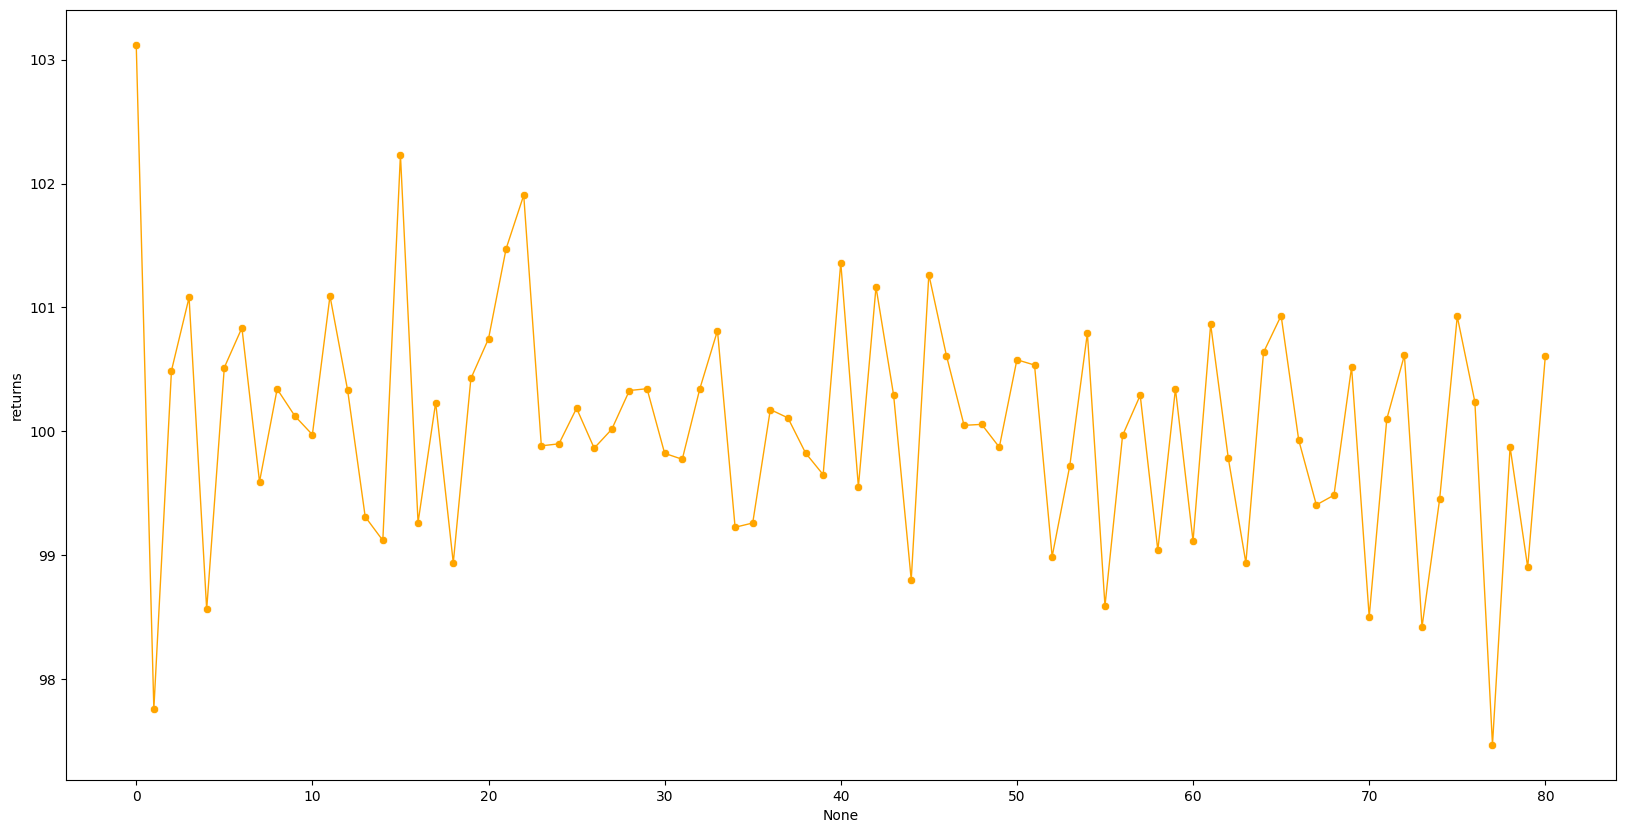

In [6]:
chevron_df = format(chevron_df)
graph_df(chevron_df)

/tmp/ipykernel_171640/2666347190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = (((df["Close"] - df["Open"]) / df["Open"])*100)+100


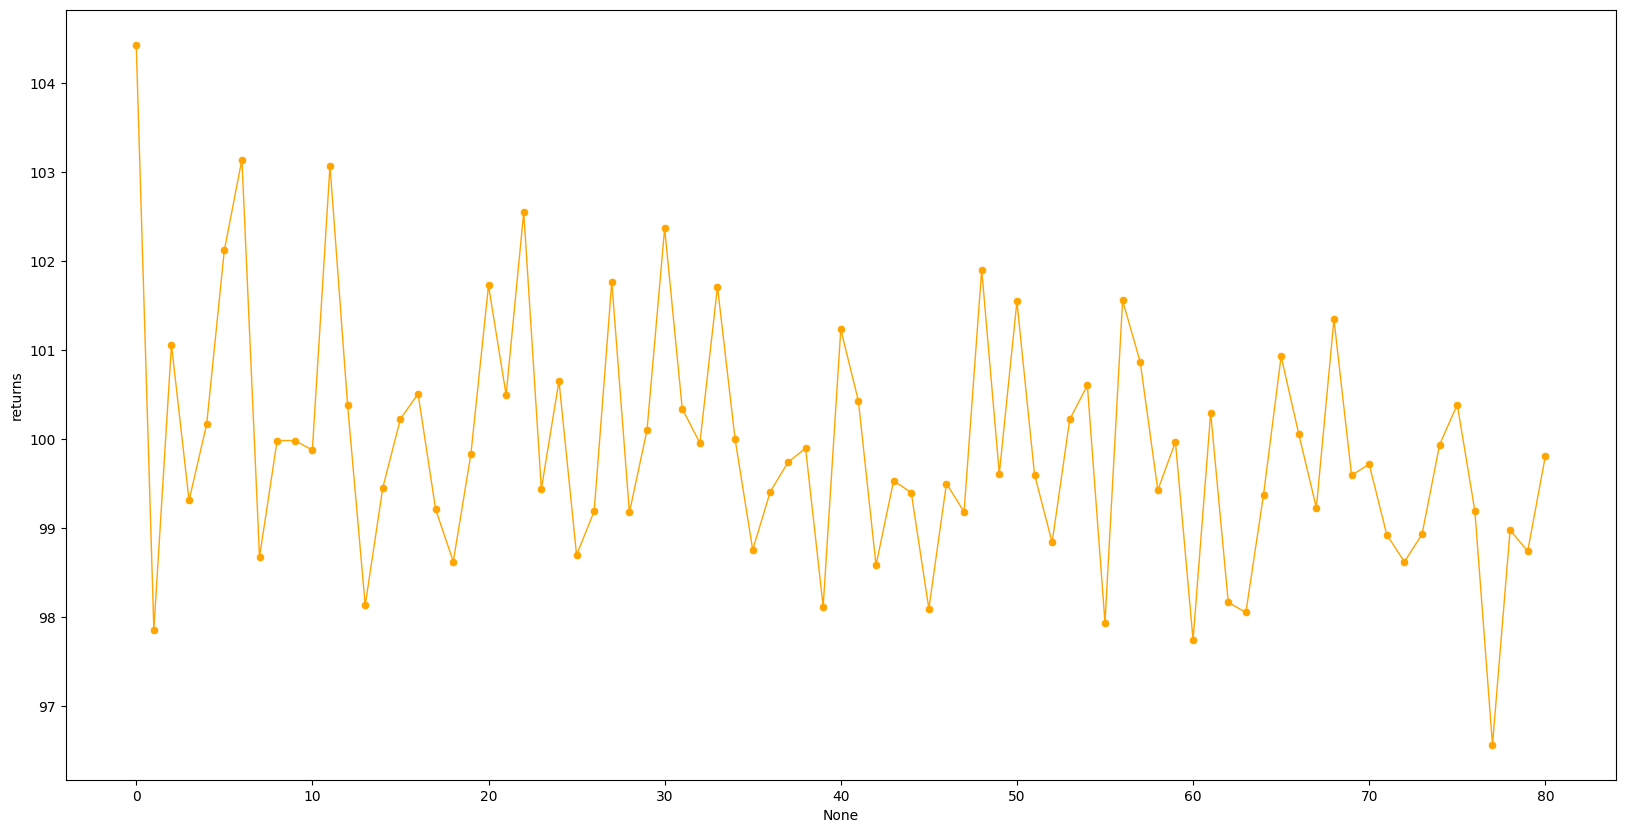

In [7]:
conoco_df = format(conoco_df)
graph_df(conoco_df)

In [8]:
exxon_df.head(), exxon_df.shape, chevron_df.head(), chevron_df.shape

(         Date       Open       High        Low      Close  Adj Close  \
 0  2019-01-02  67.349998  69.870003  67.260002  69.690002  65.563515   
 1  2019-01-03  70.000000  70.250000  68.360001  68.620003  64.556870   
 2  2019-01-04  69.639999  71.269997  69.360001  71.150002  66.937065   
 3  2019-01-07  71.250000  72.099998  70.739998  71.519997  67.285156   
 4  2019-01-08  72.540001  72.589996  71.940002  72.040001  67.774361   
 
      Volume     returns  
 0  16727200  103.474393  
 1  13866100   98.028575  
 2  16043600  102.168297  
 3  10844200  100.378943  
 4  11439000   99.310725  ,
 (81, 8),
          Date        Open        High         Low       Close   Adj Close  \
 0  2019-01-02  107.339996  111.680000  107.099998  110.690002  105.139481   
 1  2019-01-03  111.059998  111.290001  108.070000  108.570000  103.125793   
 2  2019-01-04  110.279999  110.989998  109.470001  110.820000  105.262962   
 3  2019-01-07  111.059998  112.930000  109.919998  112.260002  106.630760 

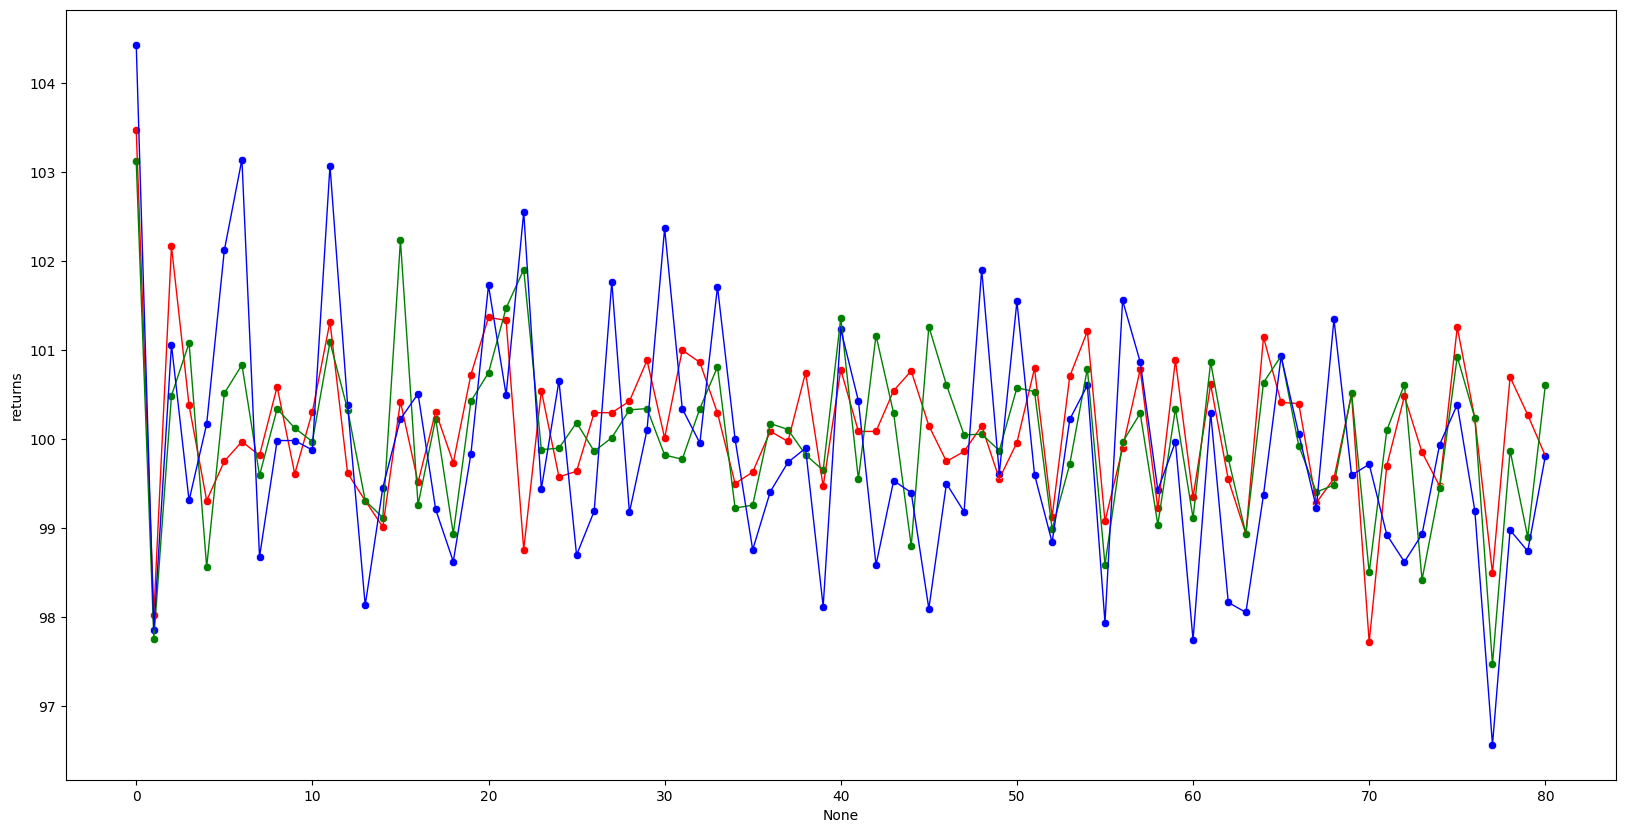

In [9]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=exxon_df, x=exxon_df.index, y="returns", color = "red")
plt.plot(exxon_df.index, exxon_df['returns'], color='red', linewidth=1)

sns.scatterplot(data=chevron_df, x=chevron_df.index, y="returns", color = "green")
plt.plot(chevron_df.index, chevron_df['returns'], color='green', linewidth=1)

sns.scatterplot(data=conoco_df, x=conoco_df.index, y="returns", color = "blue")
plt.plot(conoco_df.index, conoco_df['returns'], color='blue', linewidth=1)
plt.show()

In [ ]:
# === Cross-sectional diffusion on Exxon (XOM) & Chevron (CVX) ===
# Upgrades:
# - Cosine noise schedule
# - Frozen empirical adjacency (no edge dropout; tiny node dropout)
# - Stronger conditioning during training
# - Proper inpainting-style conditioning: keep conditioned node consistent with *forward* noising
# - Classifier-Free Guidance (low w)
# - EMA
# - Long training + cosine LR
# - Jittered conditioning for corr
# - Sanity checks: historical vs model unconditional corr; conditional slope

import math, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------- Data ----------------
exxon_df["Date"] = pd.to_datetime(exxon_df["Date"])
chevron_df["Date"] = pd.to_datetime(chevron_df["Date"])
M = pd.merge(
    exxon_df[["Date","returns"]],
    chevron_df[["Date","returns"]],
    on="Date",
    suffixes=("_xom","_cvx")
).dropna()

R = M[["returns_xom","returns_cvx"]].values.astype(np.float32)  # (T,2)
mu = R.mean(axis=0, keepdims=True)
sd = R.std(axis=0, keepdims=True) + 1e-8
Rz = (R - mu) / sd
Rz = torch.from_numpy(Rz)  # (T,2)

Tlen, N = Rz.shape
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- Utilities ----------------
def batches(X, bs):
    idx = torch.randperm(X.size(0))
    for i in range(0, len(idx), bs):
        yield X[idx[i:i+bs]]

def sinusoidal_embedding(t, dim=64):
    half = dim // 2
    freqs = torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half, device=t.device))
    x = t[:, None].float() / freqs[None, :]
    emb = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
    if dim % 2: emb = F.pad(emb, (0,1))
    return emb

# ---------------- Graph / Adjacency ----------------
with torch.no_grad():
    C = np.corrcoef(Rz.numpy(), rowvar=False).astype(np.float32)  # (2,2)
    np.fill_diagonal(C, 0.0)
    A_init = torch.from_numpy(C)

# ---------------- Model ----------------
class GraphConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.lin = nn.Linear(in_ch, out_ch)
        self.skip = nn.Linear(in_ch, out_ch)
    def forward(self, x, A):
        # x: (B,N,C), A: (N,N)
        msg = torch.einsum('ij,bjc->bic', A, x)
        return F.gelu(self.lin(msg) + self.skip(x))

class Denoiser(nn.Module):
    def __init__(self, n_stocks, width=192, tdim=64, depth=4, A_init=None,
                 node_dropout_p=0.05):
        super().__init__()
        self.inp = nn.Linear(3, width)          # [x_t, cond_mask, cond_val]
        self.tproj = nn.Linear(tdim, width)
        self.gnn = nn.ModuleList([GraphConv(width, width) for _ in range(depth)])
        self.out = nn.Linear(width, 1)
        if A_init is None:
            A_init = torch.tensor([[0.0,1.0],[1.0,0.0]], dtype=torch.float32)
        # Freeze empirical adjacency as buffer
        self.register_buffer("A_fixed", A_init.clone())
        self.node_dropout_p = node_dropout_p

    def norm_A(self, train_mode=True):
        A = self.A_fixed
        A = torch.softmax(A, dim=-1)                          # row-softmax
        A = A + torch.eye(A.size(0), device=A.device)         # add self loops
        deg = A.sum(-1, keepdim=True)
        return A / (deg + 1e-8)

    def forward(self, x_t, t, cond_mask, cond_vals, _unused=None):
        B, N = x_t.shape
        # node feature dropout (train only)
        if self.training and self.node_dropout_p > 0:
            drop_mask = (torch.rand_like(x_t) < self.node_dropout_p).float()
            x_t = x_t * (1 - drop_mask)
        te = self.tproj(sinusoidal_embedding(t, self.tproj.in_features))[:, None, :]
        node_in = torch.stack([x_t, cond_mask, cond_vals], dim=-1)
        h = self.inp(node_in) + te
        A = self.norm_A(train_mode=self.training)
        for g in self.gnn:
            h = g(h, A)
        return self.out(h).squeeze(-1)

# ---------------- DDPM (cosine schedule) ----------------
class DDPM:
    def __init__(self, T=1000, device="cpu", s=0.008):
        self.device = device
        self.T = T
        ts = torch.linspace(0, 1, T+1, device=device)  # T+1 for alpha-bar endpoints
        alpha_bar = torch.cos((ts + s) / (1 + s) * math.pi/2).pow(2).clamp(1e-4, 0.9999)
        alphas = alpha_bar[1:] / alpha_bar[:-1]
        betas  = (1 - alphas).clamp(1e-5, 0.999)
        self.betas = betas
        self.alphas = alphas
        self.ac = torch.cumprod(alphas, dim=0)                 # alpha_cumprod (length T)
        self.ac_prev = torch.cat([torch.ones(1, device=device), self.ac[:-1]], dim=0)
        self.sqrt_ac = torch.sqrt(self.ac)
        self.sqrt_1m_ac = torch.sqrt(1.0 - self.ac)
        self.sqrt_recip_alpha = torch.sqrt(1.0 / self.alphas)
        self.post_var = betas * (1.0 - self.ac_prev) / (1.0 - self.ac + 1e-8)

    def q_sample(self, x0, t, noise=None):
        if noise is None: noise = torch.randn_like(x0)
        s1 = self.sqrt_ac[t][:, None]
        s2 = self.sqrt_1m_ac[t][:, None]
        return s1 * x0 + s2 * noise

# ---------------- EMA ----------------
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items()}
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1 - self.decay)
    @torch.no_grad()
    def copy_to(self, model):
        model.load_state_dict(self.shadow, strict=False)

# ---------------- Guided sampling step (Classifier-Free Guidance) ----------------
@torch.no_grad()
def p_sample_guided(model, ddpm, x_t, t, cm, cv, w=0.2):
    bt  = ddpm.betas[t][:, None]
    s1  = ddpm.sqrt_1m_ac[t][:, None]
    sra = ddpm.sqrt_recip_alpha[t][:, None]
    eps_c = model(x_t, t, cm, cv, None)
    zeros = torch.zeros_like(cm)
    eps_u = model(x_t, t, zeros, zeros, None)
    eps = (1 + w) * eps_c - w * eps_u
    mean = sra * (x_t - bt / (s1 + 1e-8) * eps)
    if (t == 0).all():
        return mean
    noise = torch.randn_like(x_t)
    var = ddpm.post_var[t][:, None]
    return mean + torch.sqrt(var) * noise

# ---------------- Instantiate ----------------
ddpm = DDPM(T=1000, device=device)
model = Denoiser(n_stocks=N, width=192, tdim=64, depth=4, A_init=A_init.to(device),
                 node_dropout_p=0.05).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=120, eta_min=1e-5)
ema = EMA(model, decay=0.999)

BATCH   = 256
EPOCHS  = 150
p_cond  = 0.50
grad_clip = 1.0

# ---------------- Train (INPAINTING-STYLE CONDITIONING) ----------------
model.train()
for ep in range(EPOCHS):
    lossv = []
    for x0 in batches(Rz, BATCH):
        x0 = x0.to(device)

        # 50% of batches: condition one random node per sample
        if torch.rand(()) < p_cond:
            pick = torch.randint(0, N, (x0.size(0),), device=device)
            cond_mask = torch.zeros_like(x0)
            cond_mask.scatter_(1, pick[:, None], 1.0)
        else:
            cond_mask = torch.zeros_like(x0)
        cond_vals = x0 * cond_mask  # ground-truth values for the "known" node(s)

        t = torch.randint(0, ddpm.T, (x0.size(0),), device=device)
        # Draw two noises: one for general q(x_t|x0), one for known nodes
        noise = torch.randn_like(x0)
        noise_known = torch.randn_like(x0)

        # Base noised sample from the *unknown* x0
        x_t = ddpm.q_sample(x0, t, noise)

        # For known nodes: overwrite x_t to be the forward-noised version of cond_vals at the same t
        if cond_mask.sum() > 0:
            s1 = ddpm.sqrt_ac[t][:, None]
            s2 = ddpm.sqrt_1m_ac[t][:, None]
            x_t_known = s1 * cond_vals + s2 * noise_known
            x_t = torch.where(cond_mask.bool(), x_t_known, x_t)

        eps_pred = model(x_t, t, cond_mask, cond_vals, None)
        # MSE to the "true" noise for all nodes
        loss = F.mse_loss(eps_pred, noise)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        ema.update(model)
        lossv.append(loss.item())

    scheduler.step()
    print(f"epoch {ep+1}/{EPOCHS}  loss={np.mean(lossv):.6f}")

# ---------------- Swap EMA weights for eval ----------------
ema.copy_to(model)
model.eval()

# ---------------- Sanity checks ----------------
hist_corr = float(M["returns_xom"].corr(M["returns_cvx"]))
print("Historical corr:", hist_corr)

@torch.no_grad()
def unconditional_corr(n=12000):
    x = torch.randn(n, N, device=device)
    cm = torch.zeros_like(x); cv = torch.zeros_like(x)
    for t_ in reversed(range(ddpm.T)):
        t = torch.full((n,), t_, device=device, dtype=torch.long)
        x = p_sample_guided(model, ddpm, x, t, cm, cv, w=0.0)  # unconditional
    X = x.cpu().numpy() * sd + mu
    return float(np.corrcoef(X[:,0], X[:,1])[0,1])

print("Model unconditional corr:", unconditional_corr())

# ---------------- Conditional sampling / stats ----------------
@torch.no_grad()
def sample_conditioned(n_samples, cond_idx, cond_value_raw, jitter_raw=1e-3, guidance_w=0.2):
    # scale condition to z-space
    mu_i, sd_i = float(mu[0, cond_idx]), float(sd[0, cond_idx])
    cond_z = (cond_value_raw - mu_i) / sd_i
    jitter_z = float(jitter_raw / sd_i)

    # per-sample fixed conditioned value (with small jitter)
    cond_vec = cond_z + torch.randn(n_samples, device=device) * jitter_z
    # per-sample fixed noise for the known coordinate (consistent across t)
    eps_known = torch.randn(n_samples, device=device)

    x = torch.randn(n_samples, N, device=device)
    cm = torch.zeros_like(x); cm[:, cond_idx] = 1.0
    cv = torch.zeros_like(x); cv[:, cond_idx] = cond_vec

    for t_ in reversed(range(ddpm.T)):
        t = torch.full((n_samples,), t_, device=device, dtype=torch.long)

        # enforce forward-consistent noising for the known coordinate at each t
        s1 = ddpm.sqrt_ac[t][:, None]          # (B,1)
        s2 = ddpm.sqrt_1m_ac[t][:, None]
        # build a (B,N) tensor for the known coordinate only
        x_known = torch.zeros_like(x)
        x_known[:, cond_idx] = s1.squeeze(1) * cond_vec + s2.squeeze(1) * eps_known
        x = torch.where(cm.bool(), x_known, x)

        x = p_sample_guided(model, ddpm, x, t, cm, cv, w=guidance_w)

        # re-enforce known coordinate after the step
        x = torch.where(cm.bool(), x_known, x)

    X = x.cpu().numpy() * sd + mu
    return X

@torch.no_grad()
def conditional_corr(cond_idx, target_idx, cond_value=0.02, n_samples=20000,
                     jitter_raw=1e-3, guidance_w=0.2):
    X = sample_conditioned(n_samples, cond_idx, cond_value,
                           jitter_raw=jitter_raw, guidance_w=guidance_w)
    a, b = X[:, cond_idx], X[:, target_idx]
    if np.std(a) < 1e-12 or np.std(b) < 1e-12: 
        return np.nan
    return float(np.corrcoef(a, b)[0,1])

@torch.no_grad()
def conditional_slope(cond_idx, target_idx, grid=np.linspace(-0.03, 0.03, 13),
                      n_per=4000, jitter_raw=1e-3, guidance_w=0.2):
    means = []
    for v in grid:
        X = sample_conditioned(n_per, cond_idx, v,
                               jitter_raw=jitter_raw, guidance_w=guidance_w)
        means.append(X[:, target_idx].mean())
    coef = np.polyfit(grid, means, 1)[0]
    return float(coef), list(zip(grid.tolist(), [float(m) for m in means]))

# ---------------- Examples ----------------
print("Corr(CVX | XOM ≈ +2%):", conditional_corr(0, 1, 0.02, n_samples=20000))
print("Corr(XOM | CVX ≈ -1%):", conditional_corr(1, 0, -0.01, n_samples=20000))

slope_01, table_01 = conditional_slope(0, 1)
print("Model conditional slope (dE[CVX]/dXOM):", slope_01)

# Historical OLS beta via numpy (no external deps)
x = M["returns_xom"].values
y = M["returns_cvx"].values
X = np.column_stack([np.ones_like(x), x])
beta_hist = np.linalg.lstsq(X, y, rcond=None)[0][1]
print("Historical beta (CVX on XOM):", float(beta_hist))

# Reverse direction (optional)
x2 = M["returns_cvx"].values
y2 = M["returns_xom"].values
X2 = np.column_stack([np.ones_like(x2), x2])
beta_hist_rev = np.linalg.lstsq(X2, y2, rcond=None)[0][1]
print("Historical beta (XOM on CVX):", float(beta_hist_rev))


epoch 1/150  loss=1.016078
epoch 2/150  loss=0.857403
epoch 3/150  loss=1.120423
epoch 4/150  loss=0.868593
epoch 5/150  loss=1.031934
epoch 6/150  loss=0.857389
epoch 7/150  loss=0.879232
epoch 8/150  loss=0.863150
epoch 9/150  loss=0.954417
epoch 10/150  loss=0.808142
epoch 11/150  loss=0.740116
epoch 12/150  loss=0.920491
epoch 13/150  loss=0.625274
epoch 14/150  loss=0.896036
epoch 15/150  loss=0.826660
epoch 16/150  loss=0.957564
epoch 17/150  loss=0.680271
epoch 18/150  loss=0.917402
epoch 19/150  loss=0.892145
epoch 20/150  loss=0.760488
epoch 21/150  loss=0.827507
epoch 22/150  loss=0.691732
epoch 23/150  loss=0.644290
epoch 24/150  loss=0.599186
epoch 25/150  loss=0.899251
epoch 26/150  loss=0.703590
epoch 27/150  loss=0.727079
epoch 28/150  loss=0.570187
epoch 29/150  loss=0.804503
epoch 30/150  loss=0.659068
epoch 31/150  loss=0.968247
epoch 32/150  loss=0.593303
epoch 33/150  loss=0.640403
epoch 34/150  loss=0.819595
epoch 35/150  loss=0.471910
epoch 36/150  loss=0.563465
e